In [1]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import wandb

In [12]:
ENTITY_NAME = "sketchy-opts"
PROJECT_NAME_BASE = "gp_inference_"
METRIC_NAME_BASE = "metrics.callback."
METRIC_NAME_MAP = {"test_rmse": "Test RMSE", "test_posterior_samples_mean_nll": "Test NLL", "train_rmse": "Train RMSE"}
X_AXIS_NAME_MAP = {"datapasses": "Datapasses",
                  "iterations": "Iterations", "time": "Time (s)"}
BOUND_FILL = 0.2

dataset = "malonaldehyde"
metric = "test_rmse"
x_axis_name = "time"

In [3]:
api = wandb.Api()

In [4]:
runs = api.runs(f"{ENTITY_NAME}/{PROJECT_NAME_BASE}{dataset}")

In [5]:
def render_in_latex():
    plt.rcParams.update({"text.usetex": True, "font.family": "serif"})

In [6]:
@dataclass(kw_only=True, frozen=True)
class MetricData:
    """Data class to hold metric data for a run."""
    metric_name: str
    metric_data: np.ndarray
    steps: np.ndarray
    cum_times: np.ndarray
    finished: bool

    def get_final_time(self) -> float:
        """Return the last element in the cum_times array."""
        if len(self.cum_times) == 0:
            raise ValueError("cum_times array is empty.")
        return self.cum_times[-1]

    def get_plotting_name(self) -> str:
        """Return the name of the metric for plotting."""
        return self.metric_name
    
    def get_plotting_xaxis(self, xaxis) -> str:
        if xaxis not in X_AXIS_NAME_MAP:
            raise ValueError(f"Invalid x-axis name: {xaxis}. Must be one of {X_AXIS_NAME_MAP}.")
        if xaxis == "datapasses":
            raise NotImplementedError("Datapasses x-axis not implemented.")
        elif xaxis == "iterations":
            return self.steps
        elif xaxis == "time":
            return self.cum_times

class WandbRun:
    def __init__(self, run):
        self.run = run

    def _get_opt_name(self) -> str:
        if self.run.config["solver_name"] == "sap":
            if self.run.config["solver_config"].get("precond_config", None):
                return r"\texttt{ADASAP}"
            else:
                return r"\texttt{ADASAP-I}"
        elif self.run.config["solver_name"] == "sdd":
            return f"SDD-{self.run.config['opt_step_size_unscaled']}"
        elif self.run.config["solver_name"] == "pcg":
            if self.run.config["solver_config"].get("precond_config", None):
                return "PCG"
        else:
            raise ValueError(f"Unknown solver name: {self.run.config['solver_name']}")
    
    @property
    def opt_name(self) -> str:
        return self._get_opt_name()
        
    def get_metric_data(self, metric: str) -> MetricData:
        full_metric_name = f"{METRIC_NAME_BASE}{metric}"
        run_hist = self.run.scan_history(
            keys=[full_metric_name, "_step", "iter_time"])

        # Extract raw data
        metric_data = np.array([x[full_metric_name] for x in run_hist])
        steps = np.array([x["_step"] for x in run_hist])
        times = np.array([x["iter_time"] for x in run_hist])

        # Identify unique step indices -- this is needed to remove duplicates
        _, unique_indices = np.unique(steps, return_index=True)
        unique_indices = np.sort(unique_indices)  # Sort to maintain original order

        # Filter to keep only unique step entries
        metric_data = metric_data[unique_indices]
        times = times[unique_indices]
        steps = steps[unique_indices]

        # Calculate cumulative times
        cum_times = np.cumsum(times)

        return MetricData(
            metric_name=METRIC_NAME_MAP[metric],
            metric_data=metric_data,
            steps=steps,
            cum_times=cum_times,
            finished=True if self.run.state == "finished" else False,
        )

In [7]:
def _compute_metric_statistics(
    metrics_list: list[MetricData],
) -> tuple[MetricData, MetricData, MetricData]:
    """
    Compute mean, minimum, and maximum for a list of MetricData objects.
    
    Args:
        metrics_list: List of MetricData objects
        
    Returns:
        Tuple of (mean_data, min_data, max_data)
    """
    # Check if all metrics have the same metric name
    reference = metrics_list[0]
    all_same_name = all(m.metric_name == reference.metric_name
                        for m in metrics_list)
    if not all_same_name:
        raise ValueError(
            "All MetricData objects must have the same metric name")

    # Check if all metrics have the same steps
    reference = metrics_list[0]
    all_same_steps = all(np.array_equal(m.steps, reference.steps)
                         for m in metrics_list)

    if not all_same_steps:
        raise ValueError("All MetricData objects must have the same steps")

    # Stack metric data along a new axis
    stacked_metrics = np.stack([m.metric_data for m in metrics_list], axis=0)

    # Stack cum_times data
    stacked_cum_times = np.stack([m.cum_times for m in metrics_list], axis=0)

    # Compute means
    mean_metrics = np.mean(stacked_metrics, axis=0)
    mean_cum_times = np.mean(stacked_cum_times, axis=0)

    # Find actual min and max values
    min_metrics = np.min(stacked_metrics, axis=0)
    max_metrics = np.max(stacked_metrics, axis=0)

    # Check if all runs are finished
    all_finished = all(m.finished for m in metrics_list)

    # Create MetricData objects for mean, min, and max
    mean_data = MetricData(
        metric_data=mean_metrics,
        steps=reference.steps,
        cum_times=mean_cum_times,
        finished=all_finished,
        metric_name=reference.metric_name
    )

    min_data = MetricData(
        metric_data=min_metrics,
        steps=reference.steps,
        cum_times=mean_cum_times,  # Using the same mean cum_times for all
        finished=all_finished,
        metric_name=reference.metric_name
    )

    max_data = MetricData(
        metric_data=max_metrics,
        steps=reference.steps,
        cum_times=mean_cum_times,  # Using the same mean cum_times for all
        finished=all_finished,
        metric_name=reference.metric_name
    )

    return mean_data, min_data, max_data

In [8]:
metrics_dict = {}
for run in runs:
    run_obj = WandbRun(run)
    opt_name = run_obj.opt_name
    if opt_name not in metrics_dict:
        metrics_dict[opt_name] = []

    metric_data = run_obj.get_metric_data(metric)
    metrics_dict[opt_name].append(metric_data)


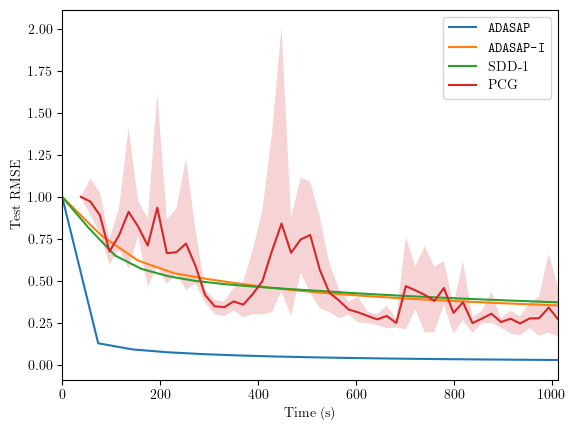

In [13]:
render_in_latex()

min_final_time = np.inf
for i, (opt_name, metric_data_list) in enumerate(list(metrics_dict.items())):
    mean_data, lower_bound_data, upper_bound_data = _compute_metric_statistics(
        metric_data_list
    )

    if i == 0:
        metric_name = mean_data.metric_name

    if mean_data.finished:
        x_axis = mean_data.get_plotting_xaxis(x_axis_name)
        plt.plot(x_axis, mean_data.metric_data, label=opt_name)
        plt.fill_between(
            x_axis,
            lower_bound_data.metric_data,
            upper_bound_data.metric_data,
            alpha=BOUND_FILL,
        )
        min_final_time = min(min_final_time, mean_data.get_final_time())
plt.xlim(0, min_final_time)
plt.xlabel(X_AXIS_NAME_MAP[x_axis_name])
plt.ylabel(metric_name)
plt.legend()
plt.show()